# BPT diagram for Voronoi-binned MUSE spectral cubes
Stephanie Juneau (NOIRLab), Emily Walla (U. of Arizona), Madison Walder (U. of Arizona), Susan Ridway (NOIRLab)

(NOTE: change the order of the authors as appropriate when modifying /working on notebook)

This notebook takes in the GIST pipeline results from running the pPXF and Gandalf steps, and plots emission-line diagnostic diagrams (such as the BPT; Baldwin et al. 1981) for the resulting fits to the input spectral datacube.

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
from   astropy.io import fits
from   astropy.table import Table, Column, join
from   mpl_toolkits.axes_grid1 import AxesGrid
import os
import optparse
import warnings
warnings.filterwarnings('ignore')
#from matplotlib.tri import Triangulation, TriAnalyzer
#from matplotlib.ticker import MultipleLocator, FuncFormatter

# to make matplotlib function well in the jupyter environment
%matplotlib inline

## Manually edit the directory of the data below

In [3]:
# define a pathway to work with:
#path_data = "../data/gistTutorial_v1p0/results/jeso-47508000-157160-50-020120_0206207550/"  #Emily
path_data = "../../../gistTutorial/results/jeso-47509200-157160-50-021320_0213208900A/"   #Stephanie
run_name = "jeso-47509200-157160-50-021320"   #part of the filenames before "_suffix.fits"

## Function to overplot dividing lines on emission-line diagrams

In [2]:
def add_lines(plot='bpt',col='red',alpha=1,ax='None'):

    if ax=='None': ax = plt

    if plot=='bpt':
        xKa03 = np.arange(-2,0.05,0.05)              #Kaufmann et al (2003)
        yKa03 = 0.61 / (xKa03 - 0.05) + 1.3
        xKe01 = np.arange(-2,0.47,0.05)              #Kewley et al (2001)
        yKe01 = 0.61 / (xKe01 - 0.47) + 1.19
        ax.plot(xKa03,yKa03,color=col,alpha=alpha)
        ax.plot(xKe01,yKe01,color=col,alpha=alpha)
        
    if plot=='bpt_oi':
        xKe06 = np.arange(-3,-0.59,0.05)              #Kewley et al (2006)
        yKe06 = 0.73 / (xKe06 + 0.59) + 1.33
        ax.plot(xKe06,yKe06,color=col,alpha=alpha)
        xliner = np.arange(-1.12,0,0.05) 
        yliner = 1.18 * xliner + 1.3
        ax.plot(xliner,yliner,color=col,alpha=alpha)

    if plot=='bpt_sii':
        xKe06 = np.arange(-2,0.32,0.05)              #Kewley et al (2006)
        yKe06 = 0.72 / (xKe06 - 0.32) + 1.30
        ax.plot(xKe06,yKe06,color=col,alpha=alpha)
        xliner = np.arange(-.31,1.5,0.05) 
        yliner = 1.89 * xliner + 0.76
        ax.plot(xliner,yliner,color=col,alpha=alpha)


## Function to output BPT Classification given input line ratios

In [219]:
def get_emlineclass(xx,yy,plot='bpt'):

    #help(xx)
    N = len(xx)
    bptclass = np.array(['bpt_class']*N, dtype=np.str)
    
    if plot=='bpt':
        yKa03 = 0.61 / (xx - 0.05) + 1.3             #Kaufmann et al (2003)
        yKe01 = 0.61 / (xx - 0.47) + 1.19            #Kewley et al (2001)
        agnclass = (yy >= yKe01)|(xx >= 0.47)
        compclass = ((yy >= yKa03)|(xx >= 0.05))&(~agnclass)
        sfclass = (~agnclass)&(~compclass)
        # Below had problems with indices before using ".flat"
        bptclass[agnclass.flat] = 'nii_agn'
        bptclass[compclass.flat] = 'nii_comp'
        bptclass[sfclass.flat] = 'nii_sf'
        
    if plot=='bpt_oi':
        yKe06 = 0.73 / (xx + 0.59) + 1.33          #Kewley et al (2006)
        yliner = 1.18 * xx + 1.3
        agnclass = (yy >= yKe06)|(xx >= -0.59)
        sfclass = (~agnclass)
        # Below had problems with indices before using ".flat"
        bptclass[agnclass.flat] = 'oi_agn'
        bptclass[sfclass.flat] = 'oi_sf'
        
    if plot=='bpt_sii':
        yKe06 = 0.72 / (xx - 0.32) + 1.30            #Kewley et al (2006)
        yliner = 1.89 * xx + 0.76
        agnclass = (yy >= yKe06)|(xx >= 0.32)
        sfclass = (~agnclass)
        # Below had problems with indices before using ".flat"
        bptclass[agnclass.flat] = 'sii_agn'
        bptclass[sfclass.flat] = 'sii_sf'

    return(bptclass)

## Get info on the data files that we need for this notebook

In [4]:
# Given the location of the files in the cell above, specify filenames with the GIST results

# Map from Voronoi bin to spaxels (or vice versa) from this file:
#   Definition: https://abittner.gitlab.io/thegistpipeline/documentation/usage/output.html#preparatory-steps
bin_table = path_data+run_name+"_table.fits"

# GANDALF best-fit results for all emission lines (one row per *line*)
#  help: https://abittner.gitlab.io/thegistpipeline/documentation/usage/output.html#gandalf
gandalf_result = path_data+run_name+"_gandalf_BIN.fits"

In [5]:
# Check extensions of fits files
print()
print(fits.info(bin_table))
print()
print(fits.info(gandalf_result))


Filename: ../../../gistTutorial/results/jeso-47509200-157160-50-021320_0213208900A/jeso-47509200-157160-50-021320_table.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  TABLE         1 BinTableHDU     40   2500R x 10C   [J, J, D, D, D, D, D, D, D, J]   
None

Filename: ../../../gistTutorial/results/jeso-47509200-157160-50-021320_0213208900A/jeso-47509200-157160-50-021320_gandalf_BIN.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  EMISSION_SETUP    1 BinTableHDU     42   22R x 11C   [D, D, 15A, D, 15A, 15A, D, D, D, 15A, D]   
  2  GANDALF       1 BinTableHDU     32   85R x 6C   [22D, 22D, 22D, 22D, 22D, 2D]   
None


## Read in Bin Table to get information on spaxels and bins

In [6]:
# Read in the bin table (one row per spaxel)
hdu1 = fits.open(bin_table)
bins = hdu1[1].data
hdr = hdu1[1].header

In [7]:
hdr

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   68 / length of dimension 1                          
NAXIS2  =                 2500 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   10 / number of table fields                         
TTYPE1  = 'ID      '                                                            
TFORM1  = 'J       '                                                            
TTYPE2  = 'BIN_ID  '                                                            
TFORM2  = 'J       '                                                            
TTYPE3  = 'X       '        

## Calculate distance from center for each Voronoi Bin

In [8]:
# The bins file has one row per bin. Several spaxels will have the same BIN_ID

# Print the number of spaxels, and the number of unique BIN_ID (=Nb of Voronoi bins)
print('Nb of spaxels: ',len(bins['XBIN']))
print('Nb of bins:',len(np.unique(bins['BIN_ID'])))

# Define the unique bin_ids and their indices
uniq_idx = np.unique(bins['BIN_ID'],return_index=True)
idx_only = uniq_idx[1]
print()
print("BIN_ID for unique bins:")
print(bins['BIN_ID'][idx_only])

# Define central bin
central_bin = (bins['BIN_ID']==1)
central_xbin = bins['XBIN'][central_bin][0]  #use first element as they are all identical per bin
central_ybin = bins['YBIN'][central_bin][0]  #use first element as they are all identical per bin

# Define distance from center in units of XPIX, YPIX (arcsec)
dist_center_bins = np.sqrt((bins['XBIN'][idx_only]-central_xbin)**2 + (bins['YBIN'][idx_only]-central_ybin)**2)
print()
print('Distance from center (in arcsec) for each bin:')
print(dist_center_bins)

# Define distance from center in units of XPIX, YPIX (arcsec) for all rows
dist_center = np.sqrt((bins['XBIN']-central_xbin)**2 + (bins['YBIN']-central_ybin)**2)

Nb of spaxels:  2500
Nb of bins: 85

BIN_ID for unique bins:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84]

Distance from center (in arcsec) for each bin:
[0.46043458 0.         0.41182521 0.75153177 0.55337349 0.90639452
 1.16275535 1.52315462 1.26301227 1.11946416 0.78963702 0.49517674
 0.51224994 1.20800054 1.63884934 0.96747093 1.90262976 1.53143923
 0.92086915 2.26217888 1.98031125 1.73158613 2.04401566 2.53203148
 2.89491692 2.10022486 1.36308474 1.91552865 3.21973506 2.91569143
 3.8345895  3.27360967 2.89691886 3.94950927 4.69382573 5.58903902
 4.45628319 4.19509741 4.94297481 4.24488963 2.41536747 2.65122287
 3.39357117 1.36982049 3.5221455  1.87429443 2.46186115 0.92431994
 1.80197423 2.77436234 1.91206694 1.10499245 1.4008477  1.44749784
 1.67425334 2.16521177 3.488

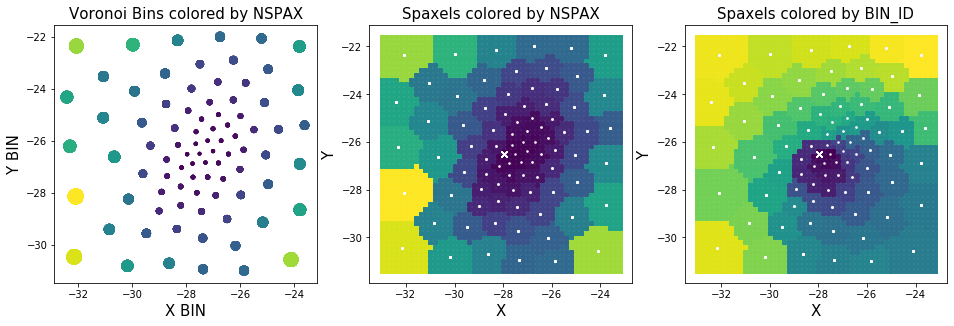

In [31]:
# XBIN, YBIN are the coordinates of each Voronoi bin, and NSPAX is the number of spaxels per bin
#

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4.75))

# Plot the location of the bins and color-code (& symbol size) them by the number of spaxels
ax1.scatter(bins['XBIN'],bins['YBIN'],s=2.*bins['NSPAX'],c=bins['NSPAX'])
ax1.set_xlabel("X BIN",fontsize=15)
ax1.set_ylabel("Y BIN",fontsize=15)
ax1.set_title("Voronoi Bins colored by NSPAX",fontsize=15)

# Plot the location of the spaxels and color-code by the number of spaxels
# Below, adjust the size "s=15" to work well with the plot size so the spaxels just fit
ax2.scatter(bins['X'],bins['Y'],marker='s',s=15,c=bins['NSPAX'])  #square markers
ax2.set_xlabel("X",fontsize=15)
ax2.set_ylabel("Y",fontsize=15)
ax2.set_title("Spaxels colored by NSPAX",fontsize=15)
ax2.scatter(bins['XBIN'][central_bin],bins['YBIN'][central_bin],marker='x',color='white')
ax2.scatter(bins['XBIN'],bins['YBIN'],s=2,color='white',alpha=0.3)

# Plot the location of the spaxels and color-code by the bin
ax3.scatter(bins['X'],bins['Y'],marker='s',s=15,c=bins['BIN_ID'])
ax3.set_xlabel("X",fontsize=15)
ax3.set_ylabel("Y",fontsize=15)
ax3.set_title("Spaxels colored by BIN_ID",fontsize=15)
ax3.scatter(bins['XBIN'][central_bin],bins['YBIN'][central_bin],marker='x',color='white')
ax3.scatter(bins['XBIN'],bins['YBIN'],s=2,color='white',alpha=0.3)

Text(0.5, 1.0, 'Voronoi Bins')

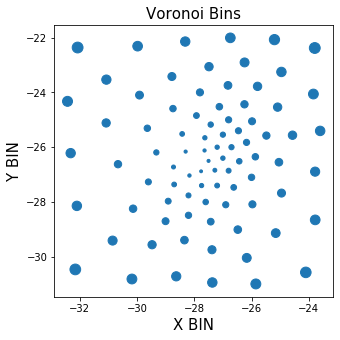

In [33]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))

# Plot the location of the bins and color-code them by distance from center
ax1.scatter(bins['XBIN'][idx_only],bins['YBIN'][idx_only],s=(dist_center_bins)*20.)
ax1.set_xlabel("X BIN",fontsize=15)
ax1.set_ylabel("Y BIN",fontsize=15)
ax1.set_title("Voronoi Bins",fontsize=15)


## Read in Gandalf results for emission lines

In [11]:
#reading data from gandalf best fit.fits
hdu2 = fits.open(gandalf_result)
setup = hdu2[1].data
hdr_setup = hdu2[1].header
gandalf = hdu2[2].data
hdr_gand = hdu2[2].header

In [12]:
hdr_setup

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  116 / length of dimension 1                          
NAXIS2  =                   22 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   11 / number of table fields                         
TTYPE1  = 'LINE_ID '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'i       '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'name    '        

In [13]:
print(setup)

[( 0.,  0., 'HeII', 3203.15, 'f', 'l', 1.  , 0., 10., 'f', 4.)
 ( 1.,  1., '[NeV]', 3345.81, 'f', 'l', 1.  , 0., 10., 'f', 4.)
 ( 2.,  2., '[NeV]', 3425.81, 'f', 'l', 1.  , 0., 10., 'f', 4.)
 ( 3.,  3., '[OII]', 3726.03, 'f', 'l', 1.  , 0., 10., 'f', 4.)
 ( 4.,  4., '[OII]', 3728.73, 'f', 'l', 1.  , 0., 10., 'f', 4.)
 ( 5.,  5., '[NeIII]', 3868.69, 'f', 'l', 1.  , 0., 10., 'f', 4.)
 ( 6.,  6., '[NeIII]', 3967.4 , 'f', 'l', 1.  , 0., 10., 'f', 4.)
 ( 7., 11., '[OIII]', 4363.15, 'f', 'l', 1.  , 0., 10., 'f', 4.)
 ( 8., 12., 'HeII', 4685.74, 'f', 'l', 1.  , 0., 10., 'f', 4.)
 ( 9., 13., '[ArIV]', 4711.3 , 'f', 'l', 1.  , 0., 10., 'f', 4.)
 (10., 14., '[ArIV]', 4740.1 , 'f', 'l', 1.  , 0., 10., 'f', 4.)
 (11., 15., 'Hb', 4861.32, 'f', 'l', 0.35, 0., 10., 'f', 4.)
 (12., 17., '[OIII]', 5006.77, 'f', 'l', 1.  , 0., 10., 'f', 4.)
 (13., 18., '[NI]', 5197.9 , 'f', 'l', 1.  , 0., 10., 't17', 4.)
 (14., 19., '[NI]', 5200.39, 'f', 'l', 1.  , 0., 10., 't17', 4.)
 (15., 20., 'HeI', 5875.6 , 'f', 'l

In [14]:
# define indices for emission lines of interest
idxHb    = np.where(setup['name']=='Hb')
idxOIII  = np.where((setup['name']=='[OIII]')&(setup['_lambda']==5006.77))
idxOI    = np.where((setup['name']=='[OI]')&(setup['_lambda']==6300.2))
idxHa    = np.where(setup['name']=='Ha')
idxNII   = np.where((setup['name']=='[NII]')&(setup['_lambda']==6583.34))
idxSII_1 = np.where((setup['name']=='[SII]')&(setup['_lambda']==6716.31))
idxSII_2 = np.where((setup['name']=='[SII]')&(setup['_lambda']==6730.68))

#double-check the indices:
print(idxHb, idxOIII, idxOI, idxHa, idxNII, idxSII_1, idxSII_2)

(array([11]),) (array([12]),) (array([16]),) (array([17]),) (array([18]),) (array([19]),) (array([20]),)


In [15]:
hdr_gand

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  896 / length of dimension 1                          
NAXIS2  =                   85 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
TTYPE1  = 'FLUX    '                                                            
TFORM1  = '22D     '                                                            
TTYPE2  = 'AMPL    '                                                            
TFORM2  = '22D     '                                                            
TTYPE3  = 'V       '        

In [16]:
print(gandalf['flux'].shape)  # Nb_bins x Nb_lines

(85, 22)


In [169]:
# Define line fluxes
f_Hb = gandalf['flux'][:,idxHb]
f_OIII = gandalf['flux'][:,idxOIII]
f_OI = gandalf['flux'][:,idxOI]
f_Ha = gandalf['flux'][:,idxHa]
f_NII = gandalf['flux'][:,idxNII]
# For [SII], need to sum the doublet flux
f_SII = gandalf['flux'][:,idxSII_1] + gandalf['flux'][:,idxSII_2]

# Define log of flux ratios
logO3Hb = np.log10(f_OIII/f_Hb)
logN2Ha = np.log10(f_NII/f_Ha)
logO1Ha = np.log10(f_OI/f_Ha)
logS2Ha = np.log10(f_SII/f_Ha)

In [174]:
# Create an Astropy table to include the line flux ratios
t_lines = Table([logO3Hb, logN2Ha, logO1Ha, logS2Ha],names=['logO3Hb','logN2Ha','logO1Ha','logS2Ha'])

# Add a column for the BIN_ID
col_id = Column(bins['BIN_ID'][idx_only],name='BIN_ID')
t_lines.add_column(col_id,index=0)

# Add a column for the distance from center (arcsec)
col_dist = Column(dist_center_bins,name='dist_center')
t_lines.add_column(col_dist)

print(t_lines[:4])
print()
print('columns: ')
print(t_lines.columns)

BIN_ID    logO3Hb [1,1]    ...    logS2Ha [1,1]       dist_center    
------ ------------------- ... ------------------- ------------------
     0  0.3217304981349723 ... -0.6272063685353055 0.4604345773288578
     1  0.4304496242560789 ... -0.5593905233999859                0.0
     2 0.33603881979400557 ... -0.6068332745030902 0.4118252056394823
     3 0.27262323506120195 ...   -0.62658084189892 0.7515317691222453

columns: 
<TableColumns names=('BIN_ID','logO3Hb','logN2Ha','logO1Ha','logS2Ha','dist_center')>


In [175]:
# Add columns for classification based on dividing lines from function
nii_class = get_emlineclass(logN2Ha, logO3Hb, plot='bpt')
col_nii = Column(nii_class,name='nii_class')  #,dtype='str')
t_lines.add_column(col_nii)

oi_class = get_emlineclass(logO1Ha, logO3Hb, plot='bpt_oi')
col_oi = Column(oi_class,name='oi_class')  #,dtype='str')
t_lines.add_column(col_oi)

sii_class = get_emlineclass(logS2Ha, logO3Hb, plot='bpt_sii')
col_sii = Column(sii_class,name='sii_class')  #,dtype='str')
t_lines.add_column(col_sii)


In [176]:
print(t_lines[:4])
print(t_lines.columns)

BIN_ID    logO3Hb [1,1]       logN2Ha [1,1]     ... nii_class oi_class sii_class
------ ------------------- -------------------- ... --------- -------- ---------
     0  0.3217304981349723  -0.1894082118581662 ...   nii_agn    oi_sf    sii_sf
     1  0.4304496242560789 -0.15781622514570345 ...   nii_agn    oi_sf    sii_sf
     2 0.33603881979400557 -0.17248537111703524 ...   nii_agn    oi_sf    sii_sf
     3 0.27262323506120195 -0.20121414477121216 ...  nii_comp    oi_sf    sii_sf
<TableColumns names=('BIN_ID','logO3Hb','logN2Ha','logO1Ha','logS2Ha','dist_center','nii_class','oi_class','sii_class')>


In [177]:
# Create a joint table by joining on BIN_ID between the bins table & t_lines table
t = join(bins,t_lines,keys='BIN_ID',join_type='left')

In [178]:
t

ID,BIN_ID,X,Y,FLUX,SNR,XBIN,YBIN,SNRBIN,NSPAX,"logO3Hb [1,1]","logN2Ha [1,1]","logO1Ha [1,1]","logS2Ha [1,1]",dist_center,nii_class,oi_class,sii_class
int32,int32,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,str9,str9,str9
1228,0,-27.40000000000022,-26.60000000000021,4483.88623046875,98.18207550048828,-27.50000000000022,-26.500000000000213,192.47064208984375,4,0.3217304981349723,-0.1894082118581662,-1.6113507756493843,-0.6272063685353055,0.4604345773288578,nii_agn,oi_sf,sii_sf
1227,0,-27.60000000000022,-26.60000000000021,4383.02490234375,98.0890884399414,-27.50000000000022,-26.500000000000213,192.47064208984375,4,0.3217304981349723,-0.1894082118581662,-1.6113507756493843,-0.6272063685353055,0.4604345773288578,nii_agn,oi_sf,sii_sf
1277,0,-27.60000000000022,-26.40000000000021,4297.4775390625,93.29299926757812,-27.50000000000022,-26.500000000000213,192.47064208984375,4,0.3217304981349723,-0.1894082118581662,-1.6113507756493843,-0.6272063685353055,0.4604345773288578,nii_agn,oi_sf,sii_sf
1278,0,-27.40000000000022,-26.40000000000021,4489.4228515625,95.52638244628906,-27.50000000000022,-26.500000000000213,192.47064208984375,4,0.3217304981349723,-0.1894082118581662,-1.6113507756493843,-0.6272063685353055,0.4604345773288578,nii_agn,oi_sf,sii_sf
1224,1,-28.200000000000223,-26.60000000000021,2632.16259765625,81.33082580566406,-27.960000000000225,-26.52000000000021,196.56661987304688,5,0.4304496242560789,-0.15781622514570345,-1.6710964770446537,-0.5593905233999859,0.0,nii_agn,oi_sf,sii_sf
1226,1,-27.80000000000022,-26.60000000000021,3970.443359375,95.84085083007812,-27.960000000000225,-26.52000000000021,196.56661987304688,5,0.4304496242560789,-0.15781622514570345,-1.6710964770446537,-0.5593905233999859,0.0,nii_agn,oi_sf,sii_sf
1225,1,-28.000000000000224,-26.60000000000021,3331.60986328125,88.31401824951172,-27.960000000000225,-26.52000000000021,196.56661987304688,5,0.4304496242560789,-0.15781622514570345,-1.6710964770446537,-0.5593905233999859,0.0,nii_agn,oi_sf,sii_sf
1275,1,-28.000000000000224,-26.40000000000021,3146.4208984375,83.8309326171875,-27.960000000000225,-26.52000000000021,196.56661987304688,5,0.4304496242560789,-0.15781622514570345,-1.6710964770446537,-0.5593905233999859,0.0,nii_agn,oi_sf,sii_sf
1276,1,-27.80000000000022,-26.40000000000021,3803.89990234375,90.08932495117188,-27.960000000000225,-26.52000000000021,196.56661987304688,5,0.4304496242560789,-0.15781622514570345,-1.6710964770446537,-0.5593905233999859,0.0,nii_agn,oi_sf,sii_sf


In [21]:
# Define a few more useful quantities
rr_central_bin = np.where(t['BIN_ID']==1)
t_central_bin = rr_central_bin[0][0]

## Plot emission-line ratio diagnostic diagrams & maps

### (a) Color-Coded by distance from center

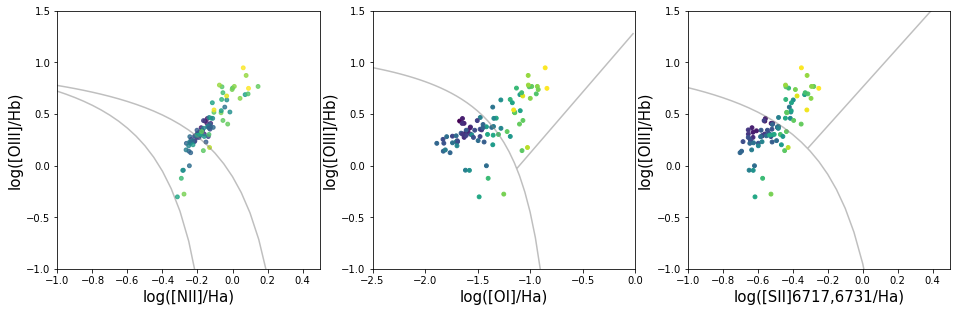

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4.75))

# color-code with distance from center

color_dist = 30*dist_center_bins

ax1.scatter(logN2Ha.flat,logO3Hb.flat,s=15,c=color_dist,alpha=0.8)  #cmap='viridis'
ax1.set_xlim(-1,0.5)
ax1.set_ylim(-1,1.5)
ax1.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax1.set_xlabel('log([NII]/Ha)',fontsize=15)
add_lines(plot='bpt',col='gray',ax=ax1,alpha=0.5)

ax2.scatter(logO1Ha.flat,logO3Hb.flat,s=15,c=color_dist)
ax2.set_xlim(-2.5,0)
ax2.set_ylim(-1,1.5)
ax2.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax2.set_xlabel('log([OI]/Ha)',fontsize=15)
add_lines(plot='bpt_oi',col='gray',ax=ax2,alpha=0.5)

ax3.scatter(logS2Ha.flat,logO3Hb.flat,s=15,c=color_dist)
ax3.set_xlim(-1,0.5)
ax3.set_ylim(-1,1.5)
ax3.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax3.set_xlabel('log([SII]6717,6731/Ha)',fontsize=15)
add_lines(plot='bpt_sii',col='gray',ax=ax3,alpha=0.5)


### (b) Color-Coded by line ratio & size-coded by distance from center

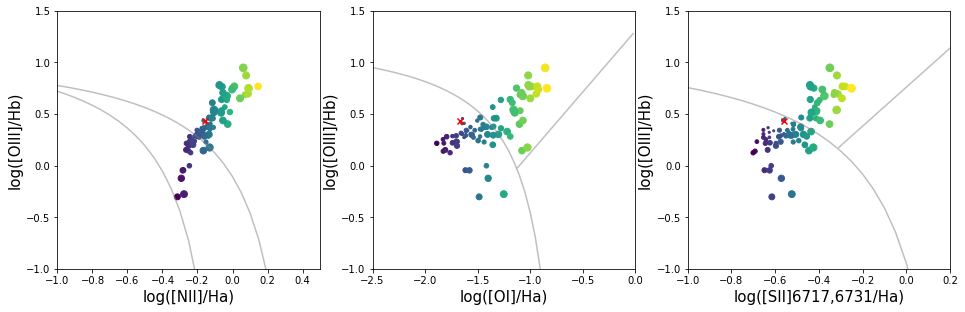

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4.75))

# color-code with line ratio
# plotting symbol size proportional to distance from center

symsize = 10*dist_center_bins
idx_center = 1   #check if zero or one

ax1.scatter(logN2Ha,logO3Hb,s=symsize,c=logN2Ha)
ax1.scatter(logN2Ha[idx_center],logO3Hb[idx_center],marker='x',color='red')   #central bin
ax1.set_xlim(-1,0.5)
ax1.set_ylim(-1,1.5)
ax1.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax1.set_xlabel('log([NII]/Ha)',fontsize=15)
add_lines(plot='bpt',col='gray',ax=ax1,alpha=0.5)

ax2.scatter(logO1Ha,logO3Hb,s=symsize,c=logO1Ha)
ax2.scatter(logO1Ha[idx_center],logO3Hb[idx_center],marker='x',color='red')   #central bin
ax2.set_xlim(-2.5,0)
ax2.set_ylim(-1,1.5)
ax2.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax2.set_xlabel('log([OI]/Ha)',fontsize=15)
add_lines(plot='bpt_oi',col='gray',ax=ax2,alpha=0.5)

ax3.scatter(logS2Ha,logO3Hb,s=symsize,c=logS2Ha)
ax3.scatter(logS2Ha[idx_center],logO3Hb[idx_center],marker='x',color='red')   #central bin
ax3.set_xlim(-1,0.2)
ax3.set_ylim(-1,1.5)
ax3.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax3.set_xlabel('log([SII]6717,6731/Ha)',fontsize=15)
add_lines(plot='bpt_sii',col='gray',ax=ax3,alpha=0.5)


### (c) Maps color-coded by emission-line ratios

Text(0.5, 1.0, 'Color-coded by log([SII]/Ha)')

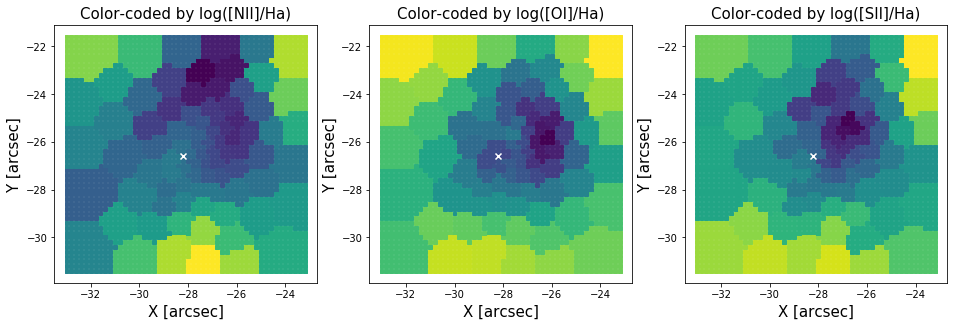

In [24]:
# Plot the spaxels color-coded by emission-line flux ratios

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4.75))

# Plot the location of the spaxels and color-code them by log([NII]/Ha)
ax1.scatter(t['X'],t['Y'],marker='s',s=15,c=t['logN2Ha'].flat)
ax1.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='white')
ax1.set_xlabel("X [arcsec]",fontsize=15)
ax1.set_ylabel("Y [arcsec]",fontsize=15)
ax1.set_title("Color-coded by log([NII]/Ha)",fontsize=15)

# Plot the location of the spaxels and color-code them by log([OI]/Ha)
ax2.scatter(t['X'],t['Y'],marker='s',s=15,c=t['logO1Ha'].flat)
ax2.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='white')
ax2.set_xlabel("X [arcsec]",fontsize=15)
ax2.set_ylabel("Y [arcsec]",fontsize=15)
ax2.set_title("Color-coded by log([OI]/Ha)",fontsize=15)

# Plot the location of the spaxels and color-code them by log([SII]/Ha)
ax3.scatter(t['X'],t['Y'],marker='s',s=15,c=t['logS2Ha'].flat)
ax3.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='white')
ax3.set_xlabel("X [arcsec]",fontsize=15)
ax3.set_ylabel("Y [arcsec]",fontsize=15)
ax3.set_title("Color-coded by log([SII]/Ha)",fontsize=15)


## Diagnostic diagrams and maps color-coded to location w.r.t. dividing lines

### (a) Color-coded strictly with classification (solid color per class: AGN, Comp, SF)

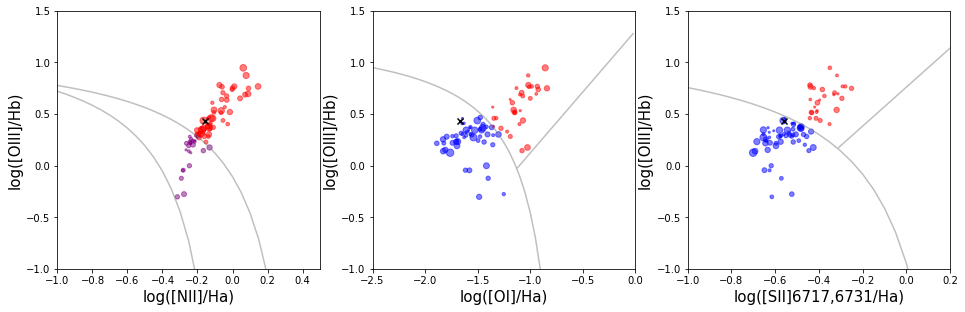

In [184]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4.75))

# color-code with line ratio
# plotting symbol size proportional to distance from center

symsize = 10*dist_center_bins
idx_center = 1   #check if zero or one

ragn = t_lines['nii_class']=='nii_agn'
rcomp = t_lines['nii_class']=='nii_comp'
rsf = t_lines['nii_class']=='nii_sf'

ax1.scatter(logN2Ha[ragn],logO3Hb[ragn],s=symsize,c='red',alpha=0.5)
ax1.scatter(logN2Ha[rcomp],logO3Hb[rcomp],s=symsize,c='purple',alpha=0.5)
ax1.scatter(logN2Ha[rsf],logO3Hb[rsf],s=symsize,c='blue')
ax1.scatter(logN2Ha[idx_center],logO3Hb[idx_center],marker='x',color='black')   #central bin
ax1.set_xlim(-1,0.5)
ax1.set_ylim(-1,1.5)
ax1.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax1.set_xlabel('log([NII]/Ha)',fontsize=15)
add_lines(plot='bpt',col='gray',ax=ax1,alpha=0.5)

ragn = t_lines['oi_class']=='oi_agn'
rsf = t_lines['oi_class']=='oi_sf'

ax2.scatter(logO1Ha[ragn],logO3Hb[ragn],s=symsize,c='red',alpha=0.5)
ax2.scatter(logO1Ha[rsf],logO3Hb[rsf],s=symsize,c='blue',alpha=0.5)
ax2.scatter(logO1Ha[idx_center],logO3Hb[idx_center],marker='x',color='black')   #central bin
ax2.set_xlim(-2.5,0)
ax2.set_ylim(-1,1.5)
ax2.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax2.set_xlabel('log([OI]/Ha)',fontsize=15)
add_lines(plot='bpt_oi',col='gray',ax=ax2,alpha=0.5)

ragn = t_lines['sii_class']=='sii_agn'
rsf = t_lines['sii_class']=='sii_sf'

ax3.scatter(logS2Ha[ragn],logO3Hb[ragn],s=symsize,c='red',alpha=0.5)
ax3.scatter(logS2Ha[rsf],logO3Hb[rsf],s=symsize,c='blue',alpha=0.5)
ax3.scatter(logS2Ha[idx_center],logO3Hb[idx_center],marker='x',color='black')   #central bin
ax3.set_xlim(-1,0.2)
ax3.set_ylim(-1,1.5)
ax3.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax3.set_xlabel('log([SII]6717,6731/Ha)',fontsize=15)
add_lines(plot='bpt_sii',col='gray',ax=ax3,alpha=0.5)


Text(0.5, 1.0, 'Color-coded by [SII] Class')

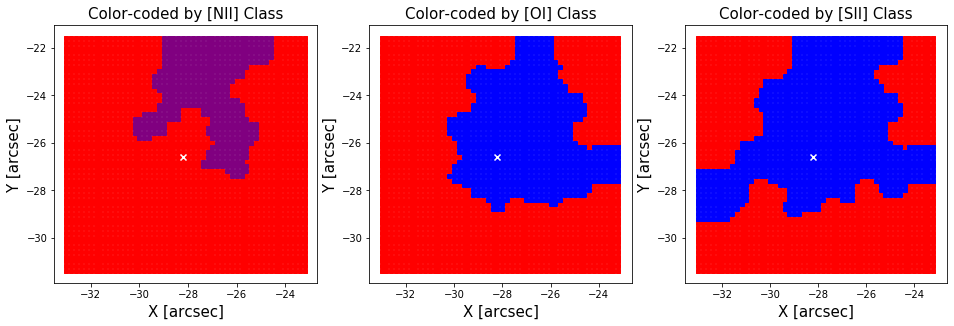

In [192]:
# Plot the spaxels color-coded by emission-line flux ratios

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4.75))

# Plot the location of the spaxels and color-code them by NII class
ragn = t['nii_class']=='nii_agn'
rcomp = t['nii_class']=='nii_comp'
rsf = t['nii_class']=='nii_sf'

ax1.scatter(t['X'][ragn],t['Y'][ragn],marker='s',s=15,c='red')
ax1.scatter(t['X'][rcomp],t['Y'][rcomp],marker='s',s=15,c='purple')
ax1.scatter(t['X'][rsf],t['Y'][rsf],marker='s',s=15,c='blue')
ax1.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='white')
ax1.set_xlabel("X [arcsec]",fontsize=15)
ax1.set_ylabel("Y [arcsec]",fontsize=15)
ax1.set_title("Color-coded by [NII] Class",fontsize=15)


# Plot the location of the spaxels and color-code them by OI class
ragn = t['oi_class']=='oi_agn'
rsf = t['oi_class']=='oi_sf'

ax2.scatter(t['X'][ragn],t['Y'][ragn],marker='s',s=15,c='red')
ax2.scatter(t['X'][rsf],t['Y'][rsf],marker='s',s=15,c='blue')
ax2.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='white')
ax2.set_xlabel("X [arcsec]",fontsize=15)
ax2.set_ylabel("Y [arcsec]",fontsize=15)
ax2.set_title("Color-coded by [OI] Class",fontsize=15)


# Plot the location of the spaxels and color-code them by SII class
ragn = t['sii_class']=='sii_agn'
rsf = t['sii_class']=='sii_sf'

ax3.scatter(t['X'][ragn],t['Y'][ragn],marker='s',s=15,c='red')
ax3.scatter(t['X'][rsf],t['Y'][rsf],marker='s',s=15,c='blue')
ax3.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='white')
ax3.set_xlabel("X [arcsec]",fontsize=15)
ax3.set_ylabel("Y [arcsec]",fontsize=15)
ax3.set_title("Color-coded by [SII] Class",fontsize=15)


### (b) Color-coded per class and with a gradient as a function of line ratio

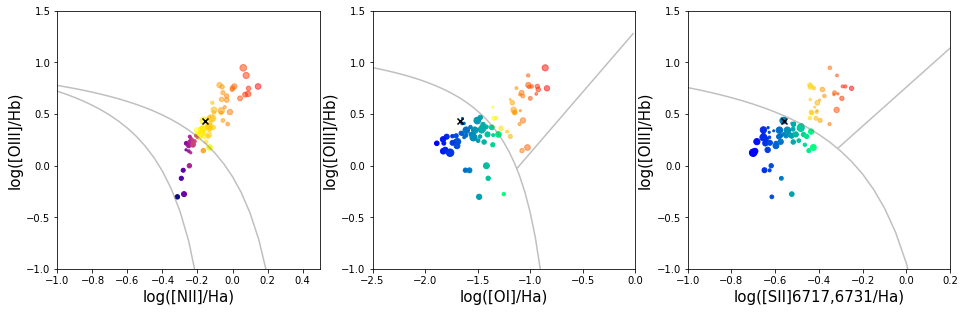

In [209]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4.75))

# color-code with line ratio
# plotting symbol size proportional to distance from center

symsize = 10*dist_center_bins
idx_center = 1   #check if zero or one

ragn = t_lines['nii_class']=='nii_agn'
rcomp = t_lines['nii_class']=='nii_comp'
rsf = t_lines['nii_class']=='nii_sf'

ax1.scatter(logN2Ha[ragn],logO3Hb[ragn],s=symsize,c=logN2Ha[ragn],alpha=0.5,cmap='autumn_r')
ax1.scatter(logN2Ha[rcomp],logO3Hb[rcomp],s=symsize,c=logN2Ha[rcomp],cmap='plasma')
ax1.scatter(logN2Ha[rsf],logO3Hb[rsf],s=symsize,c=logN2Ha[rsf],cmap='winter')
ax1.scatter(logN2Ha[idx_center],logO3Hb[idx_center],marker='x',color='black')   #central bin
ax1.set_xlim(-1,0.5)
ax1.set_ylim(-1,1.5)
ax1.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax1.set_xlabel('log([NII]/Ha)',fontsize=15)
add_lines(plot='bpt',col='gray',ax=ax1,alpha=0.5)

ragn = t_lines['oi_class']=='oi_agn'
rsf = t_lines['oi_class']=='oi_sf'

ax2.scatter(logO1Ha[ragn],logO3Hb[ragn],s=symsize,c=logO1Ha[ragn],alpha=0.5,cmap='autumn_r')
ax2.scatter(logO1Ha[rsf],logO3Hb[rsf],s=symsize,c=logO1Ha[rsf],cmap='winter')
ax2.scatter(logO1Ha[idx_center],logO3Hb[idx_center],marker='x',color='black')   #central bin
ax2.set_xlim(-2.5,0)
ax2.set_ylim(-1,1.5)
ax2.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax2.set_xlabel('log([OI]/Ha)',fontsize=15)
add_lines(plot='bpt_oi',col='gray',ax=ax2,alpha=0.5)

ragn = t_lines['sii_class']=='sii_agn'
rsf = t_lines['sii_class']=='sii_sf'

ax3.scatter(logS2Ha[ragn],logO3Hb[ragn],s=symsize,c=logS2Ha[ragn],alpha=0.5,cmap='autumn_r')
ax3.scatter(logS2Ha[rsf],logO3Hb[rsf],s=symsize,c=logS2Ha[rsf],cmap='winter')
ax3.scatter(logS2Ha[idx_center],logO3Hb[idx_center],marker='x',color='black')   #central bin
ax3.set_xlim(-1,0.2)
ax3.set_ylim(-1,1.5)
ax3.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax3.set_xlabel('log([SII]6717,6731/Ha)',fontsize=15)
add_lines(plot='bpt_sii',col='gray',ax=ax3,alpha=0.5)

Text(0.5, 1.0, 'Color-coded by [SII] Class')

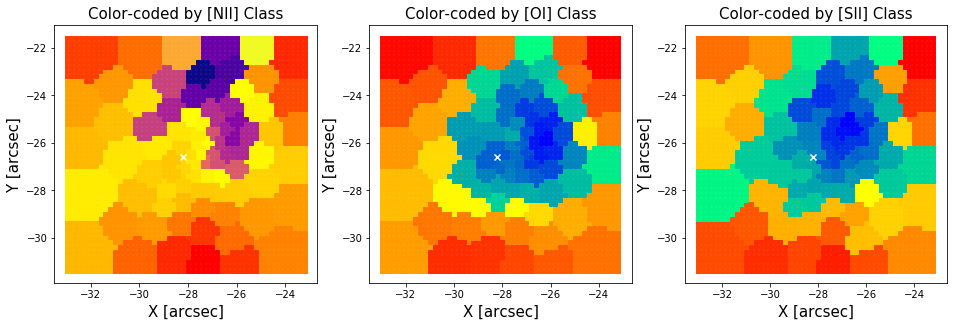

In [208]:
# Plot the spaxels color-coded by emission-line flux ratios

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4.75))

# Plot the location of the spaxels and color-code them by NII class
ragn = t['nii_class']=='nii_agn'
rcomp = t['nii_class']=='nii_comp'
rsf = t['nii_class']=='nii_sf'

ax1.scatter(t['X'][ragn],t['Y'][ragn],marker='s',s=15,c=t['logN2Ha'][ragn].flat,cmap='autumn_r')
ax1.scatter(t['X'][rcomp],t['Y'][rcomp],marker='s',s=15,c=t['logN2Ha'][rcomp].flat,cmap='plasma')
ax1.scatter(t['X'][rsf],t['Y'][rsf],marker='s',s=15,c=t['logN2Ha'][rsf].flat,cmap='winter')
ax1.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='white')
ax1.set_xlabel("X [arcsec]",fontsize=15)
ax1.set_ylabel("Y [arcsec]",fontsize=15)
ax1.set_title("Color-coded by [NII] Class",fontsize=15)


# Plot the location of the spaxels and color-code them by OI class
ragn = t['oi_class']=='oi_agn'
rsf = t['oi_class']=='oi_sf'

ax2.scatter(t['X'][ragn],t['Y'][ragn],marker='s',s=15,c=t['logO1Ha'][ragn].flat,cmap='autumn_r')
ax2.scatter(t['X'][rsf],t['Y'][rsf],marker='s',s=15,c=t['logO1Ha'][rsf].flat,cmap='winter')
ax2.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='white')
ax2.set_xlabel("X [arcsec]",fontsize=15)
ax2.set_ylabel("Y [arcsec]",fontsize=15)
ax2.set_title("Color-coded by [OI] Class",fontsize=15)


# Plot the location of the spaxels and color-code them by SII class
ragn = t['sii_class']=='sii_agn'
rsf = t['sii_class']=='sii_sf'

ax3.scatter(t['X'][ragn],t['Y'][ragn],marker='s',s=15,c=t['logS2Ha'][ragn].flat,cmap='autumn_r')
ax3.scatter(t['X'][rsf],t['Y'][rsf],marker='s',s=15,c=t['logS2Ha'][rsf].flat,cmap='winter')
ax3.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='white')
ax3.set_xlabel("X [arcsec]",fontsize=15)
ax3.set_ylabel("Y [arcsec]",fontsize=15)
ax3.set_title("Color-coded by [SII] Class",fontsize=15)

### (c) Different color maps but color-coding per class and per line ratio value again

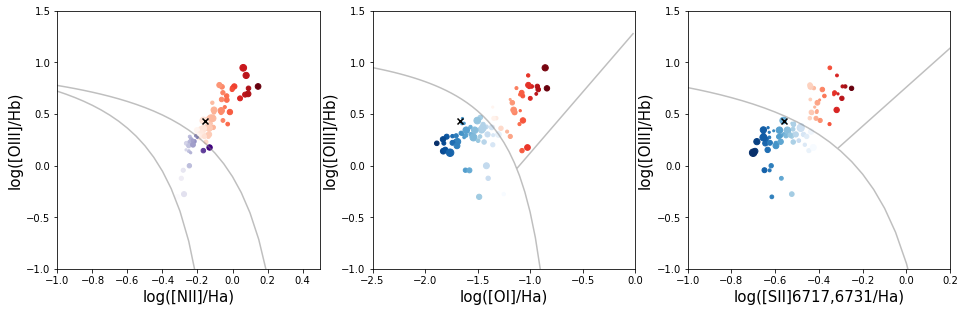

In [218]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4.75))

# color-code with line ratio
# plotting symbol size proportional to distance from center

symsize = 10*dist_center_bins
idx_center = 1   #check if zero or one

ragn = t_lines['nii_class']=='nii_agn'
rcomp = t_lines['nii_class']=='nii_comp'
rsf = t_lines['nii_class']=='nii_sf'

ax1.scatter(logN2Ha[ragn],logO3Hb[ragn],s=symsize,c=logN2Ha[ragn],cmap='Reds')
ax1.scatter(logN2Ha[rcomp],logO3Hb[rcomp],s=symsize,c=logN2Ha[rcomp],cmap='Purples')
ax1.scatter(logN2Ha[rsf],logO3Hb[rsf],s=symsize,c=logN2Ha[rsf],cmap='Blues_r')
ax1.scatter(logN2Ha[idx_center],logO3Hb[idx_center],marker='x',color='black')   #central bin
ax1.set_xlim(-1,0.5)
ax1.set_ylim(-1,1.5)
ax1.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax1.set_xlabel('log([NII]/Ha)',fontsize=15)
add_lines(plot='bpt',col='gray',ax=ax1,alpha=0.5)

ragn = t_lines['oi_class']=='oi_agn'
rsf = t_lines['oi_class']=='oi_sf'

ax2.scatter(logO1Ha[ragn],logO3Hb[ragn],s=symsize,c=logO1Ha[ragn],cmap='Reds')
ax2.scatter(logO1Ha[rsf],logO3Hb[rsf],s=symsize,c=logO1Ha[rsf],cmap='Blues_r')
ax2.scatter(logO1Ha[idx_center],logO3Hb[idx_center],marker='x',color='black')   #central bin
ax2.set_xlim(-2.5,0)
ax2.set_ylim(-1,1.5)
ax2.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax2.set_xlabel('log([OI]/Ha)',fontsize=15)
add_lines(plot='bpt_oi',col='gray',ax=ax2,alpha=0.5)

ragn = t_lines['sii_class']=='sii_agn'
rsf = t_lines['sii_class']=='sii_sf'

ax3.scatter(logS2Ha[ragn],logO3Hb[ragn],s=symsize,c=logS2Ha[ragn],cmap='Reds')
ax3.scatter(logS2Ha[rsf],logO3Hb[rsf],s=symsize,c=logS2Ha[rsf],cmap='Blues_r')
ax3.scatter(logS2Ha[idx_center],logO3Hb[idx_center],marker='x',color='black')   #central bin
ax3.set_xlim(-1,0.2)
ax3.set_ylim(-1,1.5)
ax3.set_ylabel('log([OIII]/Hb)',fontsize=15)
ax3.set_xlabel('log([SII]6717,6731/Ha)',fontsize=15)
add_lines(plot='bpt_sii',col='gray',ax=ax3,alpha=0.5)

Text(0.5, 1.0, 'Color-coded by [SII] Class')

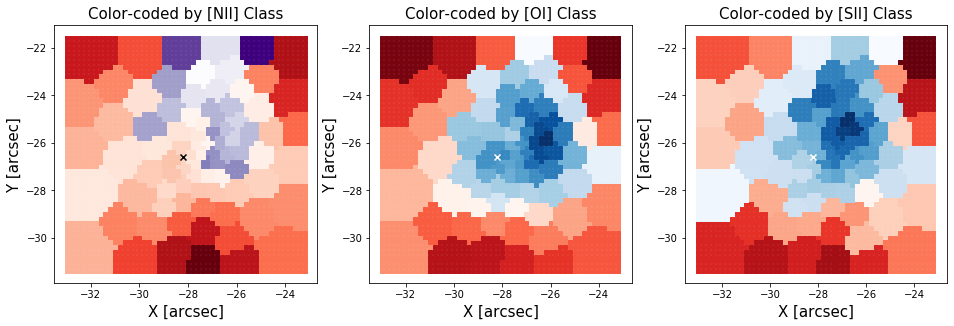

In [220]:
# Plot the spaxels color-coded by emission-line flux ratios

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4.75))

# Plot the location of the spaxels and color-code them by NII class
ragn = t['nii_class']=='nii_agn'
rcomp = t['nii_class']=='nii_comp'
rsf = t['nii_class']=='nii_sf'

ax1.scatter(t['X'][ragn],t['Y'][ragn],marker='s',s=15,c=t['logN2Ha'][ragn].flat,cmap='Reds')
ax1.scatter(t['X'][rcomp],t['Y'][rcomp],marker='s',s=15,c=t['logN2Ha'][rcomp].flat,cmap='Purples')
ax1.scatter(t['X'][rsf],t['Y'][rsf],marker='s',s=15,c=t['logN2Ha'][rsf].flat,cmap='Blues_r')
ax1.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='black')
ax1.set_xlabel("X [arcsec]",fontsize=15)
ax1.set_ylabel("Y [arcsec]",fontsize=15)
ax1.set_title("Color-coded by [NII] Class",fontsize=15)


# Plot the location of the spaxels and color-code them by OI class
ragn = t['oi_class']=='oi_agn'
rsf = t['oi_class']=='oi_sf'

ax2.scatter(t['X'][ragn],t['Y'][ragn],marker='s',s=15,c=t['logO1Ha'][ragn].flat,cmap='Reds')
ax2.scatter(t['X'][rsf],t['Y'][rsf],marker='s',s=15,c=t['logO1Ha'][rsf].flat,cmap='Blues_r')
ax2.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='white')
ax2.set_xlabel("X [arcsec]",fontsize=15)
ax2.set_ylabel("Y [arcsec]",fontsize=15)
ax2.set_title("Color-coded by [OI] Class",fontsize=15)


# Plot the location of the spaxels and color-code them by SII class
ragn = t['sii_class']=='sii_agn'
rsf = t['sii_class']=='sii_sf'

ax3.scatter(t['X'][ragn],t['Y'][ragn],marker='s',s=15,c=t['logS2Ha'][ragn].flat,cmap='Reds')
ax3.scatter(t['X'][rsf],t['Y'][rsf],marker='s',s=15,c=t['logS2Ha'][rsf].flat,cmap='Blues_r')
ax3.scatter(t['X'][t_central_bin],t['Y'][t_central_bin],marker='x',color='white')
ax3.set_xlabel("X [arcsec]",fontsize=15)
ax3.set_ylabel("Y [arcsec]",fontsize=15)
ax3.set_title("Color-coded by [SII] Class",fontsize=15)